### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Вывод по шагу 1

> Напутаны типы и есть пропуски. cityCenters_nearest - плохое название столбца. На следующем шаге переименуем в city_centers_nearest

### Шаг 2. Предобработка данных

#### 2.1 определите и изучите пропущенные значения:

Рассеивание по высоте потолков


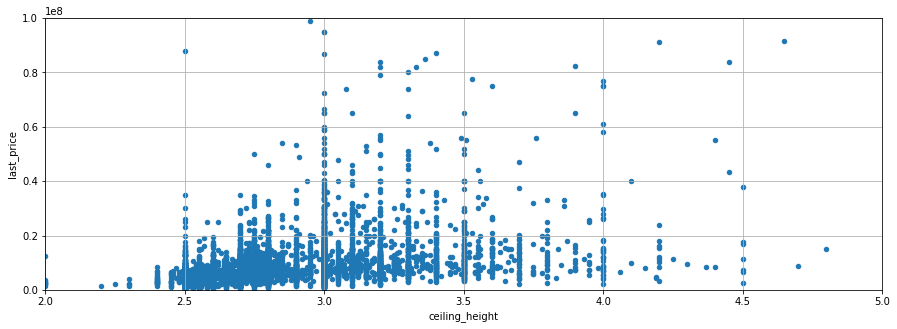

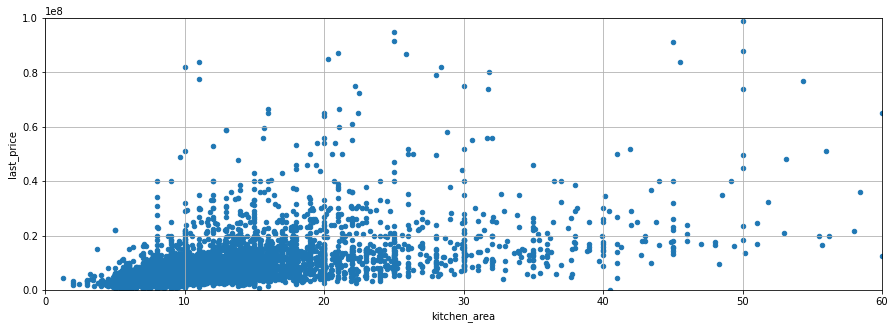

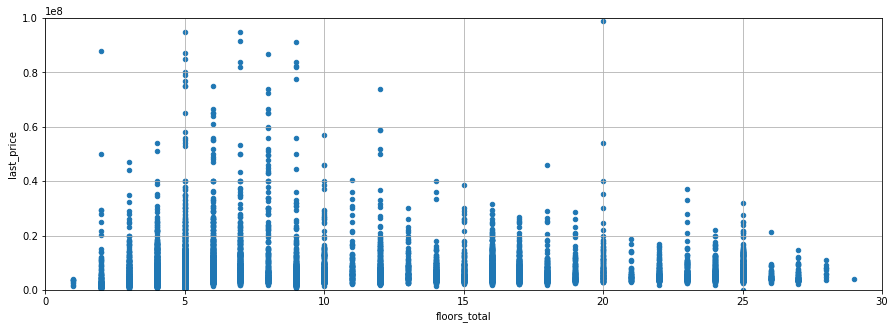

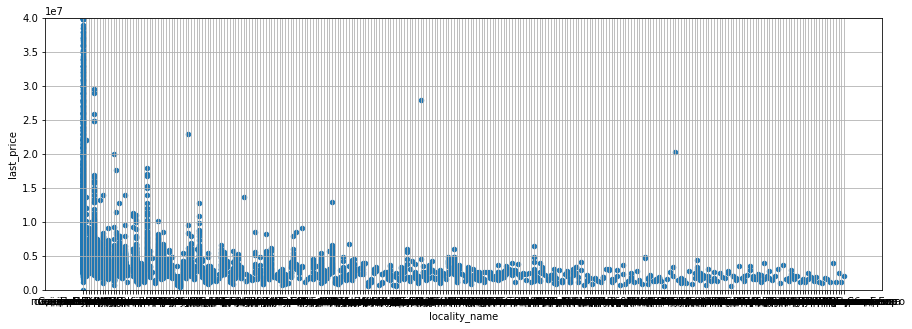

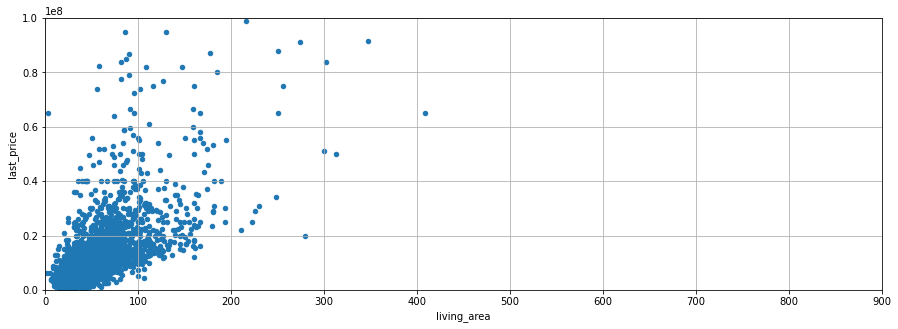

In [2]:
#  Смотрим какие могут быть данные, где логично заменить пропуск на 0:
#  - балконы
#  - аппартаменты
#  ну и все

data['balcony'].fillna(0, inplace = True)
data['is_apartment'].fillna(0, inplace = True)

# Дальше, в данных пользователей у нас есть пропуски в:
# - высота потолков
# - площадь кухни
# - этажность дома
# - жилая площадь
# - место расположения

# Т.к. основная цель нашего проекта связана со стоимостью квартир, то имеет смысл для начала оченить насколько нам важны те данные, для которых существуют пропуски. 

data_wo_na = data.dropna(subset=['ceiling_height', 'kitchen_area', 'floors_total', 'locality_name','living_area']) # создаем таблицу без пропусков в указанных столбцах
#data.info()

# на выходе мы получили 13 318 записей без пропусков в данных заполняемых пользователем. В принципе уже неплохая выборка. 56% от генеральной совокупности
# теперь по каждому из наших параметров строим диаграму рассеивания
print ('Рассеивание по высоте потолков')
data_wo_na .plot(y='last_price', x='ceiling_height', kind='scatter', figsize=(15,5), grid = True, xlim=(2,5), ylim=(0,100000000))
data_wo_na .plot(y='last_price', x='kitchen_area', kind='scatter', figsize=(15,5), grid = True, xlim=(0,60), ylim=(0,100000000))
data_wo_na .plot(y='last_price', x='floors_total', kind='scatter', figsize=(15,5), grid = True, xlim=(0,30), ylim=(0,100000000)) 
data_wo_na .plot(y='last_price', x='locality_name', kind='scatter', figsize=(15,5), grid = True, ylim=(0,40000000)) # лимит по стоимостям ниже, чтобы исключить влияние СПБ
data_wo_na .plot(y='last_price', x='living_area', kind='scatter', figsize=(15,5), grid = True, xlim=(0,900), ylim=(0,100000000))

In [3]:
# По 'ceiling_height', 'kitchen_area' и 'floors_total' влияние не очень большое, а по этажность вообще разнонаправленное 
# А вот 'locality_name' и 'living_area' очень важны! Посмотрим что это в коэффициентах

corr_data = data_wo_na .corr()
corr_data['last_price'].sort_values(ascending=False)

last_price             1.000000
total_area             0.705463
living_area            0.613575
kitchen_area           0.535491
rooms                  0.402344
parks_around3000       0.173227
ponds_around3000       0.170550
total_images           0.115911
ceiling_height         0.087329
days_exposition        0.084687
floor                  0.040072
floors_total           0.009235
balcony               -0.011393
parks_nearest         -0.023421
airports_nearest      -0.028316
ponds_nearest         -0.119527
cityCenters_nearest   -0.224218
studio                      NaN
open_plan                   NaN
Name: last_price, dtype: float64

In [4]:
# Неожиданно площадь кухни! Значит я не правильно прочитал график. И тут вот какое соображение. Пощадь кухни и жилая кухня входят в общую площадь. Чем больше ОП, тем большее ЖП и ПК. 
# Пропорционально? Если да, то нам не нужно ничего, кроме полной площади

corr_data['total_area'].sort_values(ascending=False)

total_area             1.000000
living_area            0.943268
rooms                  0.774894
last_price             0.705463
kitchen_area           0.615254
parks_around3000       0.184800
ponds_around3000       0.161415
days_exposition        0.154106
total_images           0.110208
ceiling_height         0.099463
balcony                0.006254
floor                 -0.001303
parks_nearest         -0.025768
airports_nearest      -0.035244
floors_total          -0.048497
ponds_nearest         -0.129352
cityCenters_nearest   -0.243915
studio                      NaN
open_plan                   NaN
Name: total_area, dtype: float64

> Воот! <b>Жилая</b> площадь сильно зависима от полной! А в полной то у нас пропусков не было. Поэтому пропуски в жилой площади можно легко заполнять любыми значениями. При оценке влиятия жилой площади будет отбирать "чистые данные". А для определения влиятельных на стомимость характеристик будем использовать полную. 

> Тоже относится к <b>высоте потолков</b> В смысл они не сильно влияют и можно их заполнять нулями

> C <b>этажностью</b> зданий другая ситуация - она сама не важна, но она не даст определить нам где в здании находится квартира! Поэтому от записей с пропусками в этажности лучше отказаться совсем.

> <b>Площадь кухни</b> влияет на стоимость и мы никак не можем восстановить эти данные. Поэтому от них тоже придется отказаться

> <b>Расположение</b> - таже история. Влияние сильное, а восстаовить пропуски не получится.

> Итак, делаем новую таблицу без пропусков

In [5]:
data.dropna(subset=['kitchen_area', 'floors_total', 'locality_name'], inplace=True) # создаем таблицу без пропусков в указанных столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21343 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21343 non-null  int64  
 1   last_price            21343 non-null  float64
 2   total_area            21343 non-null  float64
 3   first_day_exposition  21343 non-null  object 
 4   rooms                 21343 non-null  int64  
 5   ceiling_height        13546 non-null  float64
 6   floors_total          21343 non-null  float64
 7   living_area           20905 non-null  float64
 8   floor                 21343 non-null  int64  
 9   is_apartment          21343 non-null  object 
 10  studio                21343 non-null  bool   
 11  open_plan             21343 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               21343 non-null  float64
 14  locality_name         21343 non-null  object 
 15  airports_nearest   

> Получили 21 343 записей в выборке. 90%! Но радоваться рано - есть еще пропуски в географических данных и days_exposition

>  С географией на данном этапе можно поступить просто - все заполнить нулями чтобы можно было преобразовать тип. Сейчас нам эти данные не особо важны, а потом можно будет разобраться и с нулями

> C days_exposition видимо придется поступить также, только надо глянуть нет ли там нулей сейчас

In [6]:
data['days_exposition'].describe()

count    18371.000000
mean       185.428501
std        222.466196
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

> Все в порядке. Можно все заполнить нулями.

In [7]:
data.fillna(0, inplace = True)


#### 2.2 приведите данные к нужным типам: поясните, в каких столбцах нужно изменить тип данных и почему.

In [8]:
data['last_price'] = data['last_price'].astype(int) # стоимоть в рублях. Коппейки нам не нужны
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition']) # Даты к датам
data['floors_total']  = data['floors_total'].astype(int) # Нет дробным этажам!
data['is_apartment']  = data['is_apartment'].astype(bool) 
data['balcony'] =  data['balcony'].astype(int) # Не целые балконы тоже не нужны 

data['airports_nearest'] = data['airports_nearest'].astype(int) # всю географию приводим к метрам без сантиметров
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['parks_nearest'] = data['parks_nearest'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['ponds_nearest'] = data['ponds_nearest'].astype(int)

data['days_exposition'] = data['days_exposition'].astype(int) # целых дней достаточно для наших целей

#data.info()

#### 2.3 + приведение имен столбцов к нужному формату

In [9]:
try: 
    data.rename(columns = {'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)
except: 
    print ('Столбец cityCenters_nearest уже переименован')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21343 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21343 non-null  int64         
 1   last_price            21343 non-null  int32         
 2   total_area            21343 non-null  float64       
 3   first_day_exposition  21343 non-null  datetime64[ns]
 4   rooms                 21343 non-null  int64         
 5   ceiling_height        21343 non-null  float64       
 6   floors_total          21343 non-null  int32         
 7   living_area           21343 non-null  float64       
 8   floor                 21343 non-null  int64         
 9   is_apartment          21343 non-null  bool          
 10  studio                21343 non-null  bool          
 11  open_plan             21343 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

#### Выводы по шагу 2

##### 2.1 Наиболее очевидные причины появления пропусков:

- для данных пользователей - пропуск при заполнении либо отсутствие таких данных (нет данных по влощади кухни под рукой и нет возможности измерить) 
- для расчетных данных - ошибки алгоритмов или выгрузки, не указаны география квартиры, возможно особенности расчетов не позволяют посчитать расстояние больше какого то.

### Шаг 3. Посчитайте и добавьте в таблицу:

In [10]:
# цену квадратного метра

data['meter_price'] = (round(data['last_price'] / data ['total_area'])).astype(int) # коппейки не нужны

#день недели, месяц и год публикации объявления;

data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#этаж квартиры; варианты — первый, последний, другой;

for index, row in data.iterrows():
    descr = 'неизвестно' # т.к. у нас были пропуски в этажности зданий
    
    if row['floors_total'] > 1: #для оноэтажного строения пусть этаж будет "первый"
        if row['floor'] == row['floors_total']:
            descr = 'последний'
        else:
            descr = 'другой'
    
    if row['floor'] == 1: 
        descr = 'первый'
    
    data.loc[index,'floor_description'] = descr

#соотношение жилой и общей площади, а также отношение площади кухни к общей.

data['living_area_rel'] =  round(data['living_area'] / data ['total_area'],2) # двух знаков после запятой должно быть достаточно
data['kitchen_area_rel'] =  round(data['kitchen_area'] / data ['total_area'],2)

###                            Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:
<br><hr><br>
#### 4.1 Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.
<br><hr><br>
##### 4.1.1 Площадь квартиры
<br>

In [11]:
data['total_area'].describe()

count    21343.000000
mean        60.708130
std         35.018318
min         14.000000
25%         40.530000
50%         52.390000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

> 14 метровые квартиры выглядят странно, но возможно. В Москве есть даже 12 метровые и это реальность. 900 метровая выглядит солидно. Скорее всего она обрежется как выброс в следующих шагах, но сейчас она нам гистограму то растянет

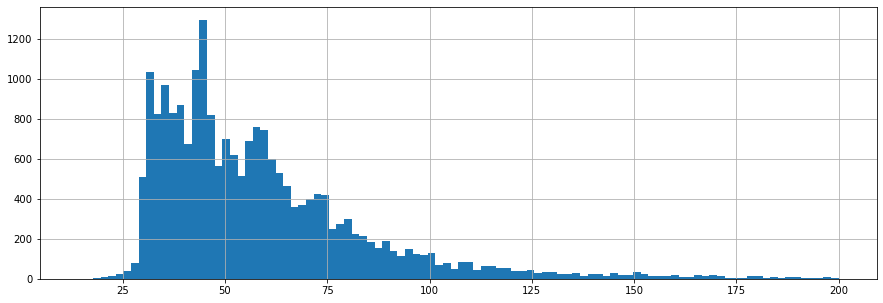

In [12]:
#data['total_area'].hist(figsize=(15,5), bins=50) # Как и предполагалось. Но зато видно, что первое приближение можно делать от 14 до 300 метров
#data['total_area'].hist(figsize=(15,5), bins=50, range=(14,300)) # поучается что то похожее на мощное логнормальное распределение, приблизим еще
data['total_area'].hist(figsize=(15,5), bins=100, range=(14,200))

> Из гистограмм видно, что оновная масса квартир сосредоточена в диапазоне от 30 до 100 метров. А что нам покажет ящик с усами

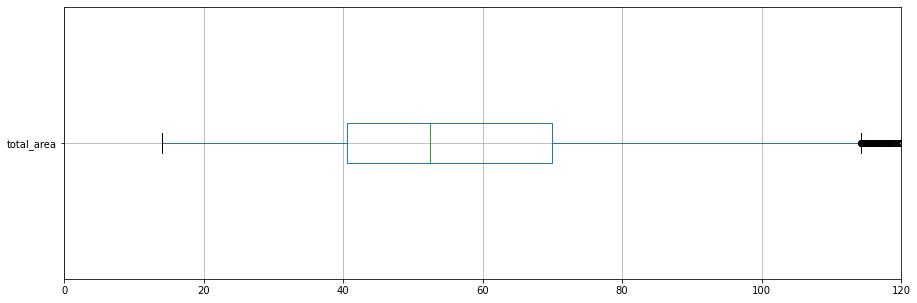

In [13]:
data['total_area'].plot(x='total_area', kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,120)) 

In [14]:
data.query('total_area <= 114')['total_area'].count()

20210

> Ящик говорит нам что нормальные значения вверх простираются до 114 метров. Внизу выбросов нет вообще. В указанном диапазне у нас 20120 записей (94% от всех)

<br><hr><br>
##### 4.1.2 Стоимость квартиры
<br>

In [15]:
data.drop(data[data['days_exposition'] == 0].index, inplace=True) # см. вывод в пункте 4.2.1 


data['last_price'].describe()

data['last_price'].count()

18371

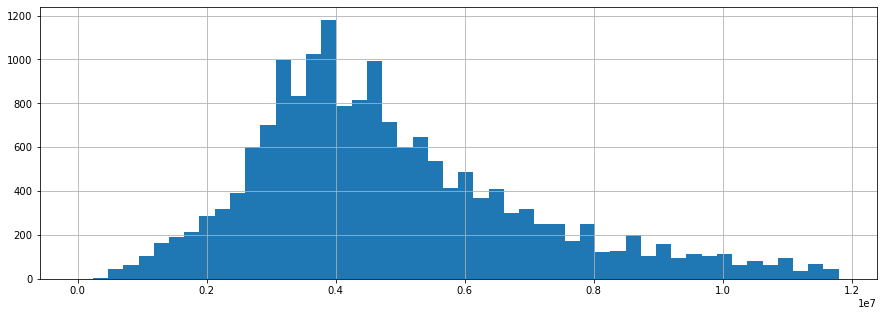

In [16]:
data['last_price'].hist(figsize=(15,5), bins=50, range=(0,11800000))

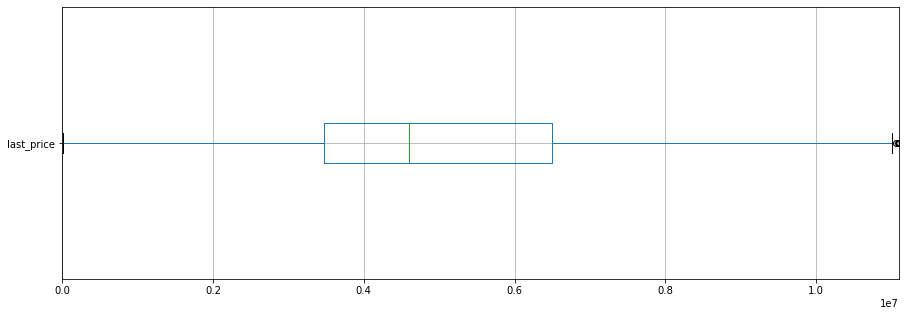

In [17]:
data['last_price'].plot(x='last_price', kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,11100000) ) 

In [18]:
data.query('last_price <= 111000000')['last_price'].count()

18345

> Выбросы начинаются с 111 000 000 (примерно) Ниже этой суммы продаются 18 345 квартир. Т.е. почти все, после отсечениях еще не проданных
<br><hr><br>
##### 4.1.3 Число комнат
<br>

In [19]:
data['rooms'].describe()

count    18371.000000
mean         2.047956
std          1.038003
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

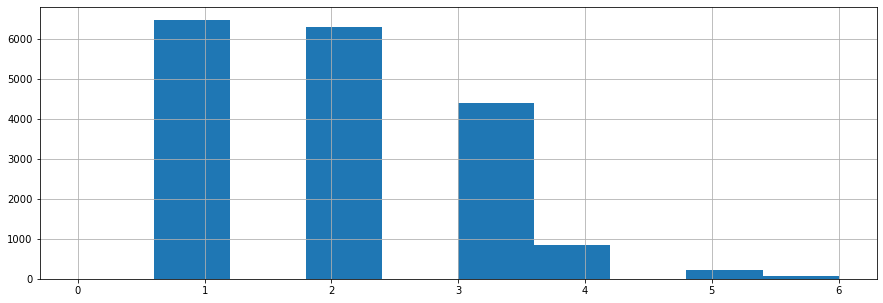

In [20]:
data['rooms'].hist(figsize=(15,5), range=(0,6))

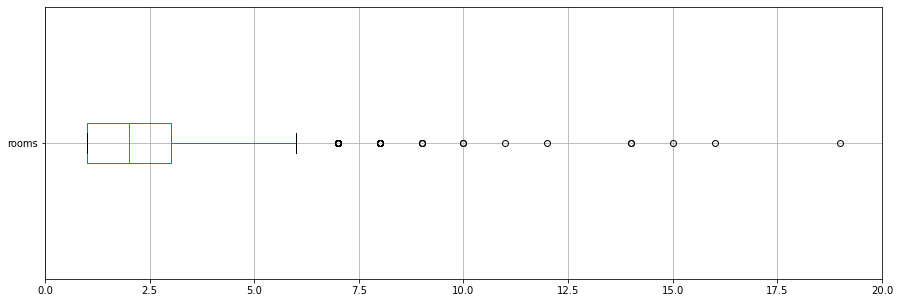

In [21]:
data['rooms'].plot(x='rooms', kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,20) ) 

> Выбросы после 6 комнат. Больше всего одно- и двухкомнатных квартир. На третьем месте трешки. 
<br><hr><br>
##### 4.1.4 Высота потолков
<br>
> Помним про большое количество пропусков

In [22]:
data[data['ceiling_height'] > 0]['ceiling_height'].describe()

count    11218.000000
mean         2.753609
std          1.227709
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

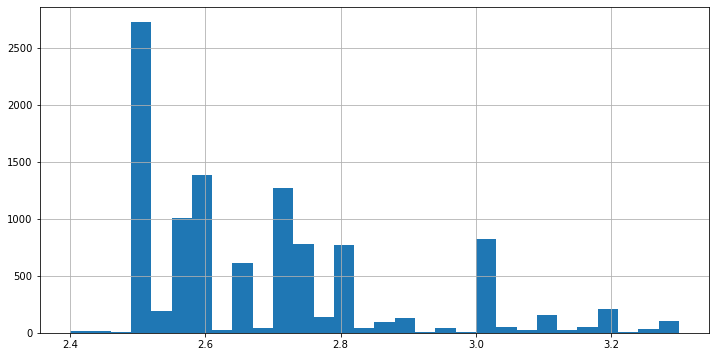

In [23]:
data['ceiling_height'].hist(bins=30, figsize=(12,6), range=(2.4,3.3)) # range появился позднее, по ходу работы 

> Ага, есть выбросы от 1 и до 100 метров. Само распределение похоже на Пуассона, но в данном случае я думаю это норма - подавляющее большинство квартир будут иметь потолки 2,5 - 3 метра. Ну может 3.2

>> Вот кстати да, поиграв с range'м можно увидеть что основные пики это 2.5, 2.6, 2.7, 2.8 и 3 метра. Есть небольшой пик на 3.2 и совсем небольшой на 2.9 Мусор между пиками скорее всего ошибки измерений. Думаю это прямой намек разбить все высоты на несколько категорий...

> А что у нас с высокими потолками?

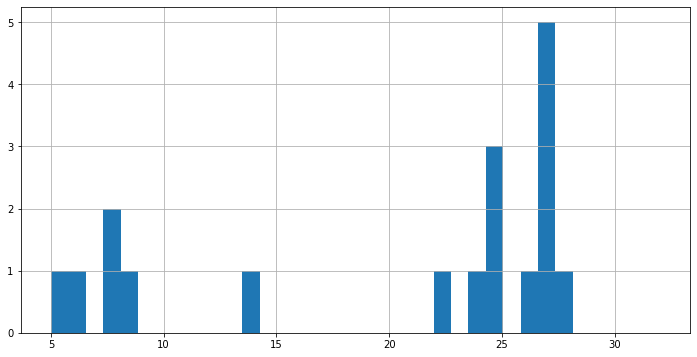

In [24]:
data['ceiling_height'].hist(bins=35, figsize=(12,6), range=(5,32)) # после 40 идет один выброс в 100 метров. 

> Опять же перебором range удалось обнаружить что:
    
- Есть еще два популярных размера: 3.3 и 3.5
- Между ними притулился 3.4. Не уверен что при категоризации его будет иметь смысл выделать в отдельный 
- Мелкие пики на 3.6 и 4 метра Дальше небольшие количества вплоть до 6 метров. 
- Новая активность возникает в диапазоне от 20 до 32 метров - это видимо потерянные точки. На самом деле это 2.0 - 3.2
- После 32 идет один единственный выброс в 100 метров


> Для начала разберемся с потерянными запятыми - это единственная достоверная корректировка

In [25]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<20, data['ceiling_height']/10)

> Теперь можно построить ящик с усами и потом перестроить гистограмму

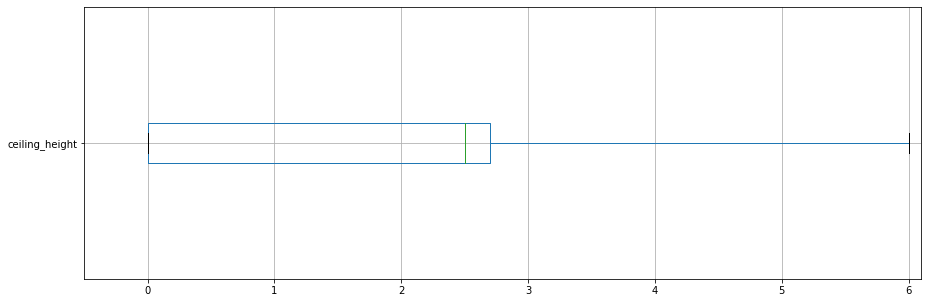

In [26]:
data['ceiling_height'].plot(x='ceiling_height', kind='box', figsize=(15,5), grid = True, vert= False, xlim=(-0.5,6.1)) 

> Ну да, ящик думает что частые 0 это норма. Но мы то понимаем что все значение ниже 2.5 это ошибки. Не может быть таких потолков по нормам. Т.к. таких записей много, то прогать мы их не будем. А вот все что выше 6 метров попадает в выбросы.

#### 4.2 Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

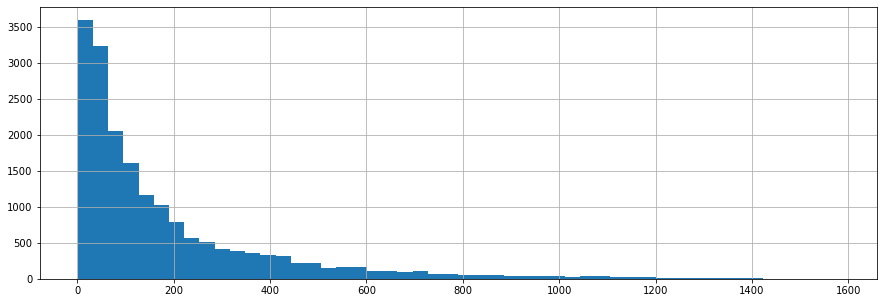

In [27]:
days_data = pd.DataFrame()
days_data['days'] = data[data['days_exposition'] > 0]['days_exposition'] # отсекаем нули, которыми мы заполняли пропуски
days_data['days'].hist(figsize=(15,5), grid = True, bins=50)

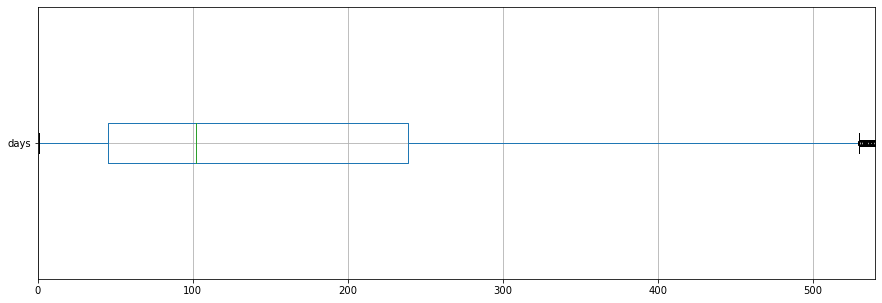

In [28]:
days_data['days'].plot(x='days', kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,540)) 

> Здесь распределение экспоненциальное. А ящик дает отсечку на 530 днях. Это все здорово, но совсем ничего не говорит о быстрых продажах. 

In [29]:
days_data['cat_exposition'] = round(days_data['days']/530,0) # Укрупним количество дней в категории

cat_data = days_data.pivot_table(index = 'cat_exposition', values='days', aggfunc = 'count') # сделаем свобднйю таблицу по категориям

#cat_data.rename(columns={'days':'sales_counter'}) # фактически в днях у нас получился счетчик записей. Не понимаю почему, но переименование не сработало. 

cat_data['perecent'] = round(cat_data['days'] / 213.43,1) # считаем сколько продалось в эту категорию дней об общего количества. Сразу в процентах
#cat_data

> К сожалению не придумал как это сделать лучше, но теперь, играясь с делителем в верхней строке можно выяснить что:

- В первые три дня продается  - 1 квартира
- В первые 5 дней - 3
- В первые 6 уже 153 - знаковый день! 
- В первые 10 дней - 449
- 20 дней - 1153
- месяц - 1743

> Ящик показал нам 530 дней - это примерно 18 месяцев

> c 17 месяца за месяц совершается меньше 1% от общего числа сделок. Согласимся с ящиком и оперделим 530 дней как нижняя граница сверхдолгих продаж. Просто долгие - более полугода (меньше 5% за месяц) быстрые - менее 17 дней (менее 5%), сверхбыстрые - неделя (менее 1% за неделю). Ну и нормальные получаются от 18 до 180 дней.

- сверхбыстрые - в течение 5 первых дней;
- быстрые - от 6 до 19 дней - менее 5% всех продаж
- нормальные - от 20 до 530 дней - 67 всех квартир продано. 

>> > Но! Есть еще гистограмма, имеющая явно выраженный излом в районе 180 дней. Наш калькулятор показывает что с этого момента продается не больше 5% квартир за месяц. Поэтому:

- нормальные - от 20 до 180 дней
- долгие - от 181 до 530
- сверхдолгие - 530+

> А теперь маленькое дополнительно исследование

##### 4.2.1 Исследование как цена за метр влияет на скорость продажи квартиры

In [30]:
def get_exposition_description(days):    
    
    if days > 0: # по прежнему не смотрим пропуски
        if days < 6:
            return 'сверхбыстро'
        elif days < 20:
            return 'быстро'
        elif days < 181:
            return 'нормально'
        elif days < 530:
            return 'долго'
        else:
            return 'сверхдолго'
   
    return 'неопределено'

for index, row in data.iterrows():
    days = row['days_exposition']
    data.loc[index,'exposition_description'] = get_exposition_description(days)

In [31]:
p_data = data.pivot_table(index = ('locality_name' , 'exposition_description'), values='meter_price', 
                          aggfunc=('median' ,'count')) # Строим сводную таблицу по населенным пунктам и скорости продаж
query = 'locality_name == "Санкт-Петербург"' # и смотрим данные по СПБ. 
p_data.query(query)

count    median
locality_name   exposition_description                  
Санкт-Петербург быстро                  1270.0  102635.5
                долго                   2972.0  102912.5
                нормально               6787.0  102606.0
                сверхбыстро              324.0  102528.0
                сверхдолго              1025.0  104545.0

>  Да, зависимость есть! И даже в нужную нам сторону. Но больно уж она не значительна. Между сверхбыстро и быстро разница в 384,5 рубля за метр. Медиана по общей площади у нас 52 метра, что дает разницу в стоимости в ~ 20 000 рублей. C другой стороны, игнорировать совсем я бы ее не стал, все таки есть разница, и на довольно большом числе записей! 

> Зато теперь стала понятна природа пропусков в days_exposition. Так как там цена самая высокая это те кто еще не успел ее снизить и реально не продали квартиру. И даже можем дать им совет: снижать цену минимум на 10%! 

> И вот эти 10% могут нам слегка испортить картину... Тут возникает глубокий филосовский вопрос. Нас интересуют предложения или реальные сделки? Если сделки, то нам надо удалить все записи о непроданных еще квартирах потому что они окажут влияние на статистику по "последней цене" И удалить их нужно было еще до анализа стоимости квартир в п. 4.1.2 Думаю все таки правильней их убрать! И именно там, в прошлом. 

> Второй абзац выглядит слегка глупо. т.к. теперь нет данных о непроданных квартирах. Но при первом проходе он была акутален. Оставил все как было чтобы показать ход мыслей.

<br><hr><br>

#### 4.3 Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

> Выше мы уже проверили 5 параметров и нашли по ним выбросы. Удаление начнем с них.

In [32]:
data.drop(data[data['total_area'] > 114].index, inplace=True)
data.drop(data[data['last_price'] > 111000000].index, inplace=True)
data.drop(data[data['rooms'] > 6].index, inplace=True)
data.drop(data[data['ceiling_height'] > 6].index, inplace=True)
data.drop(data[data['days_exposition'] > 530].index, inplace=True)

> Ну и дальше идем по порядку. Но не по всем столбцам. Например total_images нас вообще слабо интересует. Столбцы с типом bool смотреть смысла нет. А начиная с 22 вообще мы сами считали. 

- first_day_exposition - мне кажется тоже не стоит. Если только глянуть самое старое значение
- living_area - мы раньше уже выяснили что жилая площадь сильно увязана с общей. Нам остается проверить чтобы она не была больше
- floor - вот не хочется их удалять! Если они не больше общей этажности дома, то все ок!
- географию вообще смотреть не хочется - кроме расстояния до центра в дальнейших расчетах практически не участвует. Если где то вылезет высокая степень корелляции, то там на месте и посмотрим

In [33]:
data['first_day_exposition'].min() # 2015-02-19 00:00:00

#data['floors_total'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,30)) 

Timestamp('2015-02-19 00:00:00')

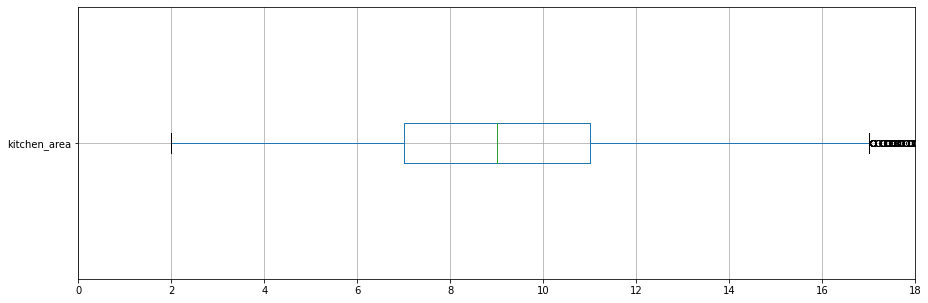

In [50]:
data.drop(data[data['floors_total'] > 29].index, inplace=True) # 60 этаж явная ошибка, а вот 37 может быть, но это экзотика

#data.query('living_area > total_area') # нет таких
#data.query('floor > floors_total') # нет таких

data['kitchen_area'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,18)) 


In [52]:
data.query('kitchen_area > 17')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,meter_price,weekday,month,year,floor_description,living_area_rel,kitchen_area_rel,exposition_description
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,48,121,100000,1,6,2018,другой,0.32,0.41,нормально
24,8,6500000,97.20,2015-10-31,2,0.00,3,46.50,1,False,...,124,265,66872,5,10,2015,первый,0.48,0.20,долго
110,6,3850000,72.30,2017-09-29,2,0.00,3,27.40,2,False,...,0,45,53250,4,9,2017,другой,0.38,0.33,нормально
116,18,10999000,97.20,2017-11-13,3,2.50,16,0.00,16,False,...,390,394,113158,0,11,2017,последний,0.00,0.19,долго
123,2,4300000,48.00,2019-04-04,1,0.00,22,14.00,5,False,...,1097,9,89583,3,4,2019,другой,0.29,0.50,быстро
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388,7,5400000,43.00,2017-04-24,1,0.00,18,12.00,8,False,...,0,124,125581,0,4,2017,другой,0.28,0.47,нормально
23416,14,8300000,64.50,2015-12-02,2,2.77,11,36.20,4,False,...,222,433,128682,2,12,2015,другой,0.56,0.28,долго
23507,4,7360000,73.83,2018-06-23,2,0.00,21,31.65,17,False,...,475,103,99688,5,6,2018,другой,0.43,0.29,нормально
23573,8,6290000,47.67,2019-03-20,1,3.60,12,13.59,12,False,...,99,19,131949,2,3,2019,последний,0.29,0.37,быстро


> Да, по размерам кухонь выбросы есть. И их много! 707 записей. О, идея! А не лучшели посмотреть на посчитанный нами kitchen_area_rel

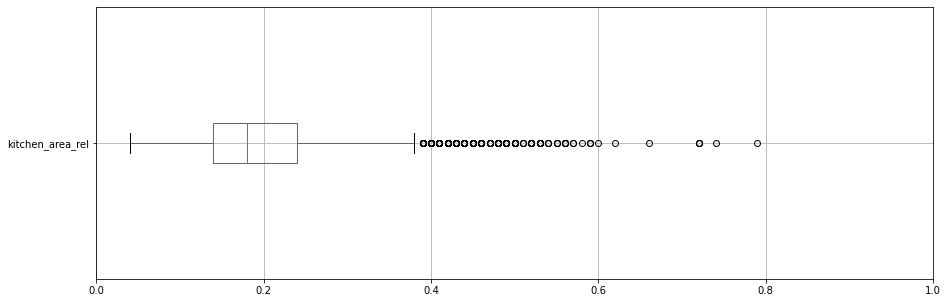

In [36]:
data['kitchen_area_rel'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,1)) 

In [37]:
data.query('kitchen_area_rel > 0.38')['kitchen_area'].count()

248

> Другое дело. Кухонь, занимающих более 38% квартиры "всего" 248. Интресено это теже кухни? Больше 17 метров? 

In [53]:
data.query('(kitchen_area_rel > 0.38) & kitchen_area > 17')['kitchen_area'].count()

180

> Ну в общем близко 180 из 248

> Видимо придется удалять и те, и другие.

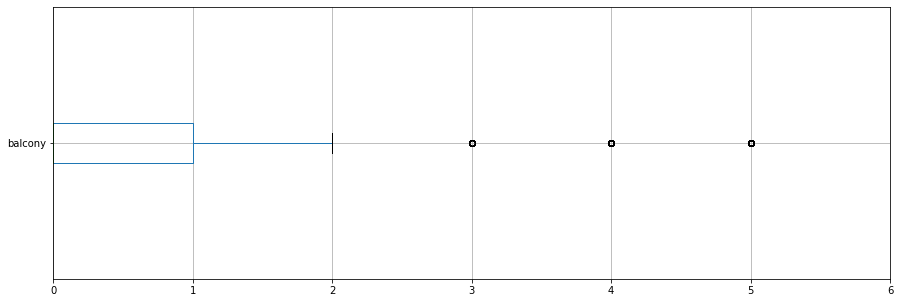

In [56]:
data.drop(data[data['kitchen_area'] > 17].index, inplace=True) 
data.drop(data[data['kitchen_area_rel'] > 0.38].index, inplace=True)

data['balcony'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,6)) 

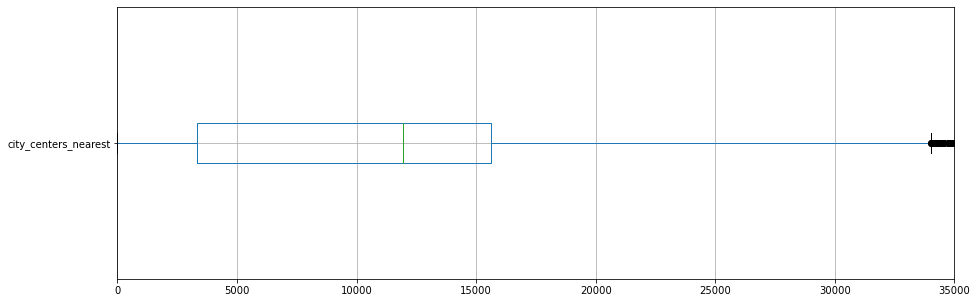

In [66]:
data.drop(data[data['balcony'] > 2].index, inplace=True)

data['city_centers_nearest'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,35000)) 

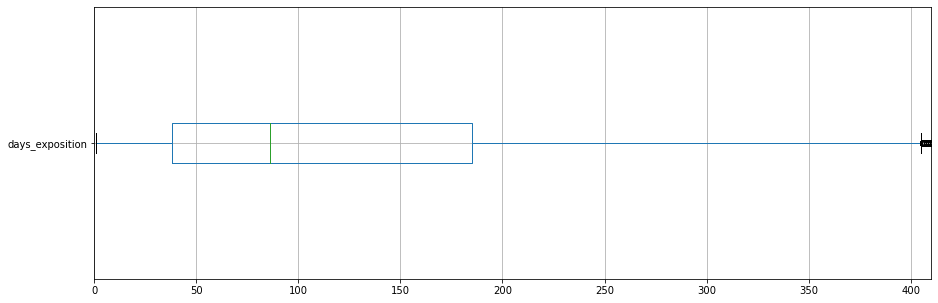

In [72]:
data.drop(data[data['city_centers_nearest'] > 34000].index, inplace=True)

data['days_exposition'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(0,410)) 

> days_exposition раньше определили что все ,что больше 530 дней - выброс. Теперь это значение уменьшилось до 405. Скорее всего это бесконечный процесс. Подчищая одно значение, мы меняем выборку по другому. Получается что сначала надо определять выбросы по всем параметрам, и только потом удалять. В следующий раз буду делать так. Здесь... переделаю если будет такое замечание ) 

> пока убираем по старому значению выбросов - 530

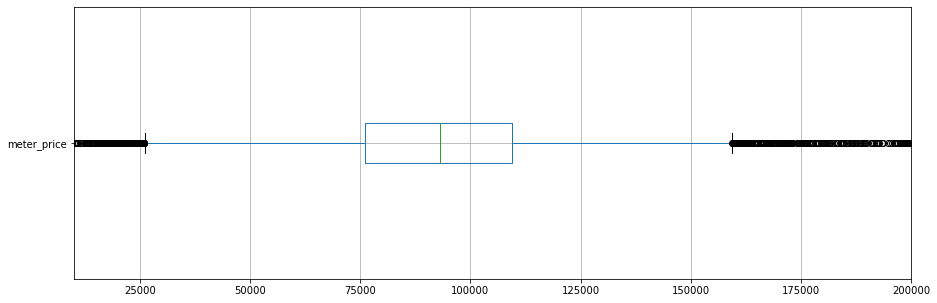

In [75]:
data.drop(data[data['days_exposition'] > 530].index, inplace=True)

data['meter_price'].plot(kind='box', figsize=(15,5), grid = True, vert= False, xlim=(10000,200000)) 

> С учетом следующих заданий принял решение пока не трогать. Дорогие метры скорее всего находятся в центре Санкт-Петербурга, и мы сильно испортим расчеты удалив их сейчас.

#### 4.4 Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.


In [78]:
corr_data = data.corr()

corr_data['last_price'].sort_values(ascending=False)

last_price              1.000000
meter_price             0.718956
total_area              0.678551
living_area             0.538438
kitchen_area            0.470444
rooms                   0.413746
ponds_around3000        0.302595
airports_nearest        0.288652
parks_around3000        0.260270
parks_nearest           0.221161
ponds_nearest           0.187216
floors_total            0.157639
total_images            0.134161
floor                   0.116451
ceiling_height          0.108683
city_centers_nearest    0.072279
living_area_rel         0.061208
days_exposition         0.036306
balcony                 0.019459
year                    0.001516
month                  -0.001567
is_apartment           -0.001718
weekday                -0.001872
kitchen_area_rel       -0.214205
studio                       NaN
open_plan                    NaN
Name: last_price, dtype: float64

> Наиболее влиятельные параметры (топ 5):

- цена за метр и общая площадь - само собой! 
- жилая площадь - тоже понятно. Она сильно связана с общей площадью
- площадь кухни! 
- количество комнат

> А вот растояние до центра один из самых слабых параметров! Видимо оказывают влияние квартиры не в Питере. В 4.6 мы еще вернемся к этому вопросу. 

In [80]:
data.pivot_table(index = 'floor_description', values=('last_price', 'meter_price'), aggfunc = 'mean')

,last_price,meter_price
floor_description,,
другой,5.117354e+06,97319.757853
первый,4.095823e+06,79361.592798
последний,4.592089e+06,85589.404352


> Ну да, все по Цою: "первый, последний не предлагать" При этом первый дешевле даже последнего

In [83]:
data.pivot_table(index = 'weekday', values=('last_price', 'meter_price'), aggfunc = 'mean')

,last_price,meter_price
weekday,,
0,4.898654e+06,93539.215704
1,4.917697e+06,92869.149092
2,4.897385e+06,94050.458588
3,5.007194e+06,93965.561194
4,4.942034e+06,93707.738962
5,4.849430e+06,92838.938038
6,4.841028e+06,93243.175490


> Самый большой разлет между субботой и четвергом - 3% По логике полный бред, но цифры не врут... или врут? Не врут! Жена подала идею что смотрины квартир все откладывают на выходные. И видят более свежие объявления четверга и пятницы.... Круто!

In [86]:
data.pivot_table(index = 'month', values=('last_price', 'meter_price'), aggfunc = 'mean')

,last_price,meter_price
month,,
1,4.968616e+06,94717.955952
2,4.872778e+06,92778.273573
3,4.936668e+06,94485.540119
4,4.924314e+06,92915.236530
5,4.834470e+06,92490.369153
6,4.977381e+06,92993.112119
7,4.870640e+06,93190.046099
8,5.006871e+06,95078.941416
9,5.073379e+06,95763.032166


> Самый большой разлет между сентябрем и маем - 4.7% Традиционно границы лета незначительно регулируют спрос.

In [87]:
data.pivot_table(index = 'year', values=('last_price', 'meter_price'), aggfunc = 'mean')

,last_price,meter_price
year,,
2015,4.896224e+06,88871.362162
2016,5.002550e+06,91637.186905
2017,4.898998e+06,91883.488024
2018,4.894327e+06,94581.916057
2019,5.102051e+06,103438.620536


#### 4.5 Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.


In [88]:
top_locality = data.pivot_table(index='locality_name', values='meter_price', aggfunc=('mean', 'count'))
top_locality['mean'] = round(top_locality['mean']/1000,0) # Точность в тысячах вполне достаточна, а выглядит лучше

top_locality.sort_values('count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,9880.0,106.0
посёлок Мурино,362.0,85.0
посёлок Шушары,333.0,77.0
Всеволожск,256.0,69.0
посёлок Парголово,234.0,90.0
Колпино,231.0,74.0
Гатчина,219.0,68.0
Пушкин,208.0,100.0
деревня Кудрово,176.0,93.0


> Лидер (ожидаемо) - Санкт-Петербург со средней стоимостью 106 тыс рублей за метр! Почетное 10 место занимает Выборг. Он почти в два раза дешевле Питера c ценой 57 000

#### 4.6 Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.
Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

<ipython-input-89-ec2c78c26758>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spb_data['city_center_km'] = round(spb_data['city_centers_nearest'] /1000 , 0)


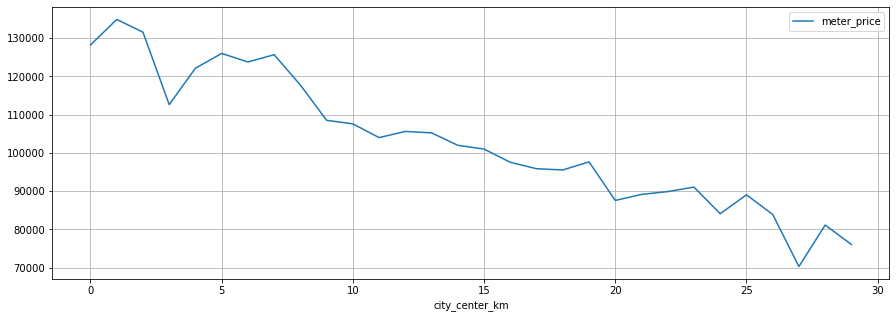

In [89]:
query = '(locality_name == "Санкт-Петербург") & (city_centers_nearest > 0)'
spb_data = data.query(query)
spb_data['city_center_km'] = round(spb_data['city_centers_nearest'] /1000 , 0)
spb_pivot = spb_data.pivot_table(index='city_center_km', values = 'meter_price', aggfunc='mean')

spb_pivot.plot(figsize=(15,5), grid = True) # лимиты потребовались для того, чтобы картинка была нагляднее

> По графику получается как минимум два центра. Первый в радиусе 1 км, второй  - 7 км. 

In [94]:
spb_center_data = data.query('(locality_name == "Санкт-Петербург") & (city_centers_nearest > 0) & (city_centers_nearest < 7000)')


spb_corr = spb_data.corr() #делаем таблицу корреляций по городу
spb_center_corr = spb_center_data.corr() # и по центру

spb_corr_un = pd.DataFrame() 

spb_corr_un['city'] = spb_corr['last_price'] # вносим их в общую таблицу для наглядности
spb_corr_un['center'] = spb_center_corr['last_price']


spb_corr_un['diff']  = round(abs(((spb_corr_un['city']-spb_corr_un['center'])/(spb_corr_un['city'] + spb_corr_un['center'])/2)),2) # и считаем разницу в коэффициентах

spb_corr_un.sort_values('diff', ascending = False)

,city,center,diff
airports_nearest,-0.026286,0.039318,2.52
balcony,0.013806,0.148435,0.41
month,-0.007779,-0.046937,0.36
weekday,0.007507,0.030284,0.30
ponds_around3000,0.203164,0.050202,0.30
is_apartment,-0.007243,-0.028006,0.29
year,0.008787,0.026795,0.25
city_centers_nearest,-0.363591,-0.132013,0.23
parks_nearest,0.105049,0.039487,0.23
floor,0.054626,0.149191,0.23


> Близость аэропорта - весь центр на примерно одинаковом удалении от Пулково, а вот окраины на разном! Т.е. те кто покупает квартиры в центре не особо смотрит на расстояние до аэропорта

> А вот балконы в центре ценяться гораздо выше! Их видимо не так много там.

> Почему различаются влияния месяцев и дней едели я не могу понять

> И еще пруды гораздо меньше влияют на стоимость квартир в центре, чем в целом по городу. Пруды. В центре Питера! Ха!


### Шаг 5. Напишите общий вывод



>> Когда ставится много задач, очень тяжело сообразить какие данные важны, а какие не очень. По хорошему, многовопросные задачи наверное нужно решать в отдельных проектах. Ну или с разными датасетами хотя бы.

>> Если есть задача удалить данные по нескольким столбцам, то сначала намечаем все точки реза, и только потом начинаем удалять

>> Странно что в географии нет близости к метро

>> Лучшее время для выставления квартиры на продажу - четверг в сентябре.